# Setting up the Dataset

In [0]:
from pathlib import Path
import requests

In [0]:
DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

In [0]:
PATH.mkdir(parents=True, exist_ok=True)
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [0]:
import pickle
import gzip
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [5]:
n, c = x_train.shape
print(x_train.shape)

(50000, 784)


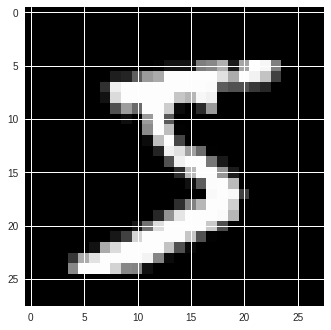

In [6]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28,28)), cmap='gray')

In [0]:
from IPython.core.debugger import set_trace
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

# Simple Network Using Pytorch

In [8]:
import math
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
biases = torch.zeros(10, requires_grad=True) 
print(weights)

tensor([[-0.0228, -0.0716, -0.0567,  ...,  0.0007, -0.0138, -0.0158],
        [-0.0067,  0.0537, -0.0146,  ...,  0.0435, -0.0686,  0.0020],
        [-0.0291,  0.0312,  0.0348,  ..., -0.0563, -0.0547, -0.0450],
        ...,
        [-0.0680,  0.0439,  0.0217,  ...,  0.0105, -0.0478,  0.0406],
        [-0.0155, -0.0254,  0.0173,  ..., -0.0976, -0.0013, -0.0329],
        [-0.0850, -0.0432,  0.0250,  ..., -0.0221, -0.0233, -0.0036]],
       requires_grad=True)


### Utility Functions


In [0]:
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(x):
  return log_softmax(x @ weights + biases)

def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

loss_func = nll

def accuracy(output, y):
  guesses = torch.argmax(output, dim=1)
  return (guesses == y).float().mean()

In [10]:
bs = 64 #batch size
xb = x_train[:bs]
yb = y_train[:bs]
preds = model(xb)
loss = loss_func(preds, yb)
print(loss, weights.grad)
loss.backward()

print(loss, weights.grad)

tensor(2.3477, grad_fn=<NegBackward>) None
tensor(2.3477, grad_fn=<NegBackward>) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [11]:
print(accuracy(preds, yb))

tensor(0.0938)


We can now run a training loop. For each iteration, we will:

* select a mini-batch of data (of size bs)
* use the model to make predictions
* calculate the loss
* loss.backward() updates the gradients of the model, in this case, weights and bias.

In [0]:
from IPython.core.debugger import set_trace

lr = 0.9
epochs = 3
for epoch in range(epochs):
  for i in range((n-1)//(bs + 1)):
#     set_trace()
    start = i * bs
    end = start + bs
    xb = x_train[start:end]
    yb = y_train[start:end]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    with torch.no_grad(): # We do this within the torch.no_grad() context manager, because we do not want these actions to be recorded for our next calculation of the gradient. 
      weights -= weights.grad * lr
      biases -= biases.grad * lr
      weights.grad.zero_()
      biases.grad.zero_()
    

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.2222, grad_fn=<NegBackward>) tensor(0.9219)


In [14]:
print(biases)

tensor([-0.8556,  0.5527,  0.3834, -0.4120,  0.0105,  2.6124, -0.3716,  1.1791,
        -2.6264, -0.4725], requires_grad=True)


# 1st Refactor using torch.nn.functional

* torch.nn.functional contains all the functions of the torch.nn library, wheras the other parts have classes.
* This part contains useful functions like the loss functions

In [0]:
import torch.nn.functional as F

loss_func = F.cross_entropy # Remember, we just refactored our log_softmax and nll using just one line. It combines softmax and nll

def model(xb):
  return (xb @ weights + biases) # We aren't also calling log_softmax in our model function, thus making our code more modular

In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.2222, grad_fn=<NllLossBackward>) tensor(0.9219)


# 2nd Refactor using torch.nn.Module
* It is used to create classes for our models
* These classes keep track of parameters and other important stuff

In [0]:
from torch import nn

class My_MNIST_Solver(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
    self.biases = nn.Parameter(torch.zeros(10))
    
  def forward(self, xb):
    return xb @ self.weights + self.biases 
    
    

In [0]:
model = My_MNIST_Solver()

Now we can use model.parameters and model.zero grad to further refactorize our training loop

In [0]:
def fit(epochs=2, lr=0.5):
  for epoch in range(epochs):
    for i in range((n -1) // (bs + 1)):
      start = i * bs
      end = start + bs
      xb = x_train[start:end]
      yb = y_train[start:end]
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      with torch.no_grad():
        for p in model.parameters():
          p -= p.grad * lr
        model.zero_grad() # Reset grads to zero for all parameter of the model

In [0]:
fit()

In [21]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.2798, grad_fn=<NllLossBackward>) tensor(0.9219)


# 3rd Refactor using nn.Linear
* nn.Linear is a predefined layer in pytorch. It's use is illustrated below.
* Note: *We don't need to initialise the parameters now.*

In [0]:
class My_MNIST_Solver(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784, 10)
  
  def forward(self, xb):
    return self.lin(xb)

In [0]:
model = My_MNIST_Solver()

In [24]:
# pre-training
print(loss_func(model(xb), yb), accuracy(model(xb), yb))
fit(epochs=20)
#post-training
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.2758, grad_fn=<NllLossBackward>) tensor(0.0469)
tensor(0.2352, grad_fn=<NllLossBackward>) tensor(0.9219)


# 4th Refactor using optim
* optim is the optimiser that we want to use.
* Also helps in refactoring the training loop

In [0]:
from torch import optim

In [0]:
def get_model(lr=0.5):
  model =  My_MNIST_Solver()
  opt = optim.SGD(model.parameters(), lr=lr)
  return model, opt

In [27]:
model, opt = get_model()
print(loss_func(model(xb), yb), accuracy(model(xb), yb))
for epoch in range(epochs):
  for i in range((n-1)//(bs+1)):
    start = i * bs
    end = start + bs
    xb = x_train[start:end]
    yb = y_train[start:end]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step() # Note: We just refactored p -= p.grad * lr and it's for loop
    opt.zero_grad()
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.3810, grad_fn=<NllLossBackward>) tensor(0.0625)
tensor(0.2679, grad_fn=<NllLossBackward>) tensor(0.9219)


# 5th Refactor using Dataset
* A Dataset can be anything that has a __ len __ function (called by Python’s standard len function) and a __ getitem __ function as a way of indexing into it.
* It allows us to easily slice along the first axis of the tensor (generally nth training example).
* TensorDataset is a wrapper around the Dataset abstract class for tensor data.

In [0]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

In [0]:
def fit(epochs=2, lr=0.5):
  for epoch in range(epochs):
    for i in range((n -1) // (bs + 1)):
      xb, yb = train_ds[i*bs: i*bs + bs]
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      with torch.no_grad():
        for p in model.parameters():
          p -= p.grad * lr
        model.zero_grad() # Reset grads to zero for all parameter of the model

# 6th Refactor using DataLoader
* It helps in iterating through a dataset

In [0]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [31]:
model, opt = get_model()
print(loss_func(model(xb), yb))
for epoch in range(epochs):
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
print(loss_func(model(xb), yb))

tensor(2.2856, grad_fn=<NllLossBackward>)
tensor(0.0714, grad_fn=<NllLossBackward>)


In [32]:
print(accuracy(model(xb), yb))

tensor(1.)


# Adding Validation Set
* Validation set doesn't require to store grads. So it takes lesser memory. Hence a larger batch size can be used.

In [0]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=2*bs)

In [34]:
model, opt = get_model()

for epoch in range(epochs):
  for xb, yb in train_dl:
    model.train() # Always written before training used by layers like BatchNorm and Dropout
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    model.eval() # Always written before evaluating used by layers like BatchNorm and Dropout
    with torch.no_grad():
      valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
  print(epoch, valid_loss)

0 tensor(23.9505)
1 tensor(25.9968)
2 tensor(29.1557)


# Extreme Refactoring


*   We will now write functions for calculating loss for a single batch.
*   And like get_model() we will create another function called get_data() to get all the Dataloaders



In [0]:
def get_data(train_ds, valid_ds, bs):
  return (
    DataLoader(train_ds, batch_size=bs, shuffle=True),
    DataLoader(valid_ds, batch_size=bs)
  )

In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
  preds = model(xb)
  loss = loss_func(preds, yb)
  
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
  
  return loss.item(), len(xb)
    
  

In [0]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

## The following 3 lines can be used to train a wide variety of models.

In [44]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3719518579483032
1 0.30234507451057435
2 0.3276525299549103


#### CNN Implementation

In [0]:
class My_MNIST_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = F.conv2d()